In [1]:
# import lib 
import torch
import GPy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
# import file
from GPcustom.models import FixedGP, FixedOnlineGP, standardize_vector, BOtorchModel
import time

#### **Objective**: We want to measure how the inversion method with schur complement is faster than with cholesky and the complexity of this inversion. We will use the FixedOnlineGP class for GPs. 

#### Build the data 

In [2]:
nb_it = 2000

# Création de la grille de points dans l'hypercube normalisé (0, 1) x (0, 1)
x_coords = np.linspace(0, 1, 10)
y_coords = np.linspace(0, 1, 10)
X_test_normed = np.array(np.meshgrid(x_coords, y_coords)).T.reshape(-1, 2)

# Génération de train_X en prenant nb_it points aléatoires avec remise dans X_test_normed
train_X_indices = np.random.choice(X_test_normed.shape[0], nb_it, replace=True)
train_X = X_test_normed[train_X_indices]

# Génération de valeurs aléatoires standardisées pour train_Y
train_Y = np.random.randn(nb_it).reshape(-1,1)
train_Y = standardize_vector(train_Y)

#### Simulate the online GPs

In [3]:
# rep = 1

# gp_dur = np.zeros((2, rep, nb_it))
# inv_dur = np.zeros((2, rep, nb_it))

# for r in range(rep):
#     gp1 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
#     gp1.set_kernel()
#     gp2 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
#     gp2.set_kernel()
#     for i in range(nb_it):

#         ## ----- 1st GP with Schur complement method ----- ##
#         tic_gp1 = time.perf_counter()
#         inv_dur1 = gp1.update(query_x = train_X[i], query_y = train_Y[i])
#         gp1.predict()
#         tac_gp1 = time.perf_counter()

#         ## ----- 2nd GP with Cholesky method ----- ##
#         inv_dur2 = gp2.update_no_schur(query_x = train_X[i], query_y = train_Y[i])
#         gp2.predict()
#         tac_gp2 = time.perf_counter()


#         gp_dur[0,r,i] = tac_gp1 - tic_gp1
#         gp_dur[1,r,i] = tac_gp2 - tac_gp1
#         inv_dur[0,r,i] = inv_dur1
#         inv_dur[1,r,i] = inv_dur2   

#         if (i + 1) % 100 == 0:
#             print(f"we have just done the {i+1} th it for the {r} th rep")  

In [4]:
# rep = 1

# gp_dur = np.zeros((1, rep, nb_it))
# inv_dur = np.zeros((1, rep, nb_it))

# for r in range(rep):
#     gp = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
#     gp.set_kernel()
#     for i in range(nb_it):

#         ## ----- GP with Schur complement method ----- ##
#         tic_gp1 = time.perf_counter()
#         inv_dur1 = gp.update(query_x = train_X[i], query_y = train_Y[i])
#         tac_up1 = time.perf_counter()
#         gp.predict()
#         tac_gp1 = time.perf_counter()

#         gp_dur[0,r,i] = tac_gp1 - tic_gp1
#         inv_dur[0,r,i] = inv_dur1  

#         if (i + 1) % 100 == 0:
#             print(f"we have just done the {i+1} th it for the {r} th rep")  

In [5]:
# np.savez("results_custom/gp_and_inv_dur_1rep_5000it_sch_and_cho.npz", 
#          gp_dur=gp_dur, 
#          inv_dur=inv_dur, 
#          description="gp_dur: array of shape (2, nb_rep=1, nb_it=5000) where gp_dur[0] is the durations of the gp with SCHUR and gp_dur[1] with CHOLESKY\inv_dur: idem but for the inversion of K duration"
#          )

In [6]:

data = np.load("results_custom/gp_and_inv_dur_1rep_10kit_sch_and_cho_new_schur_inv.npz")
print(data['description'])
gp_dur = data['gp_dur']
inv_dur = data['inv_dur']

nb_it = gp_dur.shape[2]
print(nb_it)

gp_dur: array of shape (2, nb_rep=1, nb_it=10000) where gp_dur[0] is the durations of the gp with SCHUR and gp_dur[1] with CHOLESKY
 inv_dur: idem but for the inversion of K duration
 ATTENTION: we have implemented a new schur_inverse function
10000


#### Post process

In [7]:
gp1_duration = np.mean(gp_dur[0], axis= 0)
gp2_duration = np.mean(gp_dur[1], axis= 0)

gp1_duration_std = np.std(gp_dur[0], axis= 0)
gp2_duration_std = np.std(gp_dur[1], axis= 0)

In [8]:
inv1_duration = np.mean(inv_dur[0], axis= 0)
inv2_duration = np.mean(inv_dur[1], axis= 0)

inv1_duration_std = np.std(inv_dur[0], axis= 0)
inv2_duration_std = np.std(inv_dur[1], axis= 0)

#### Plot

In [9]:
# x = np.arange(nb_it)

# plt.figure(figsize=(10, 6))

# plt.plot(x,gp2_duration, color='red', label='cholesky_gp')
# plt.fill_between(x,gp2_duration - gp2_duration_std, gp2_duration + gp2_duration_std, color='lightcoral', alpha=0.5)

# plt.plot(x,inv2_duration, color='purple', label='cholesky_inv')
# plt.fill_between(x,inv2_duration - inv2_duration_std, inv2_duration + inv2_duration_std, color='lavender', alpha=0.5)

# plt.plot(x,gp1_duration, color='blue', label='schur_gp')
# plt.fill_between(x,gp1_duration - gp1_duration_std, gp1_duration + gp1_duration_std, color='lightblue', alpha=0.5)

# plt.plot(x,inv1_duration, color='green', label='schur_inv')
# plt.fill_between(x,inv1_duration - inv1_duration_std, inv1_duration + inv1_duration_std, color='lightgreen', alpha=0.5)

# plt.xlabel('nb of queries')
# plt.ylabel('gp duration [s]')
# plt.legend()
# plt.grid()
# plt.show()

In [10]:
def mean_by_interval(vector, n):
    # Check that the vector has a length sufficient for the operation
    if len(vector) < n:
        raise ValueError("The vector length must be greater than or equal to n.")
        
    # Compute means for intervals of 10
    interval_means = [np.mean(vector[i:i+10]) for i in range(0, len(vector) - n)]
    
    return np.array(interval_means)

In [11]:
smooth_int = 20
gp1_duration_s = mean_by_interval(gp1_duration, smooth_int)
gp2_duration_s = mean_by_interval(gp2_duration, smooth_int)
inv1_duration_s = mean_by_interval(inv1_duration, smooth_int)
inv2_duration_s = mean_by_interval(inv2_duration, smooth_int)

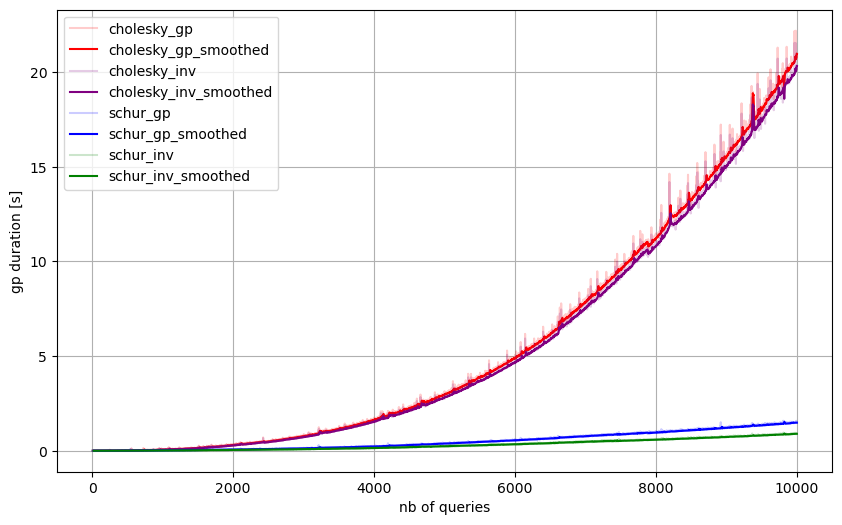

In [12]:
x = np.arange(nb_it)

plt.figure(figsize=(10, 6))

plt.plot(x,gp2_duration, color='red', label='cholesky_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp2_duration_s, color='red', label='cholesky_gp_smoothed')

plt.plot(x,inv2_duration, color='purple', label='cholesky_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv2_duration_s, color='purple', label='cholesky_inv_smoothed')

plt.plot(x,gp1_duration, color='blue', label='schur_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp1_duration_s, color='blue', label='schur_gp_smoothed')

plt.plot(x,inv1_duration, color='green', label='schur_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv1_duration_s, color='green', label='schur_inv_smoothed')

plt.xlabel('nb of queries')
plt.ylabel('gp duration [s]')
plt.legend()
plt.grid()
plt.show()

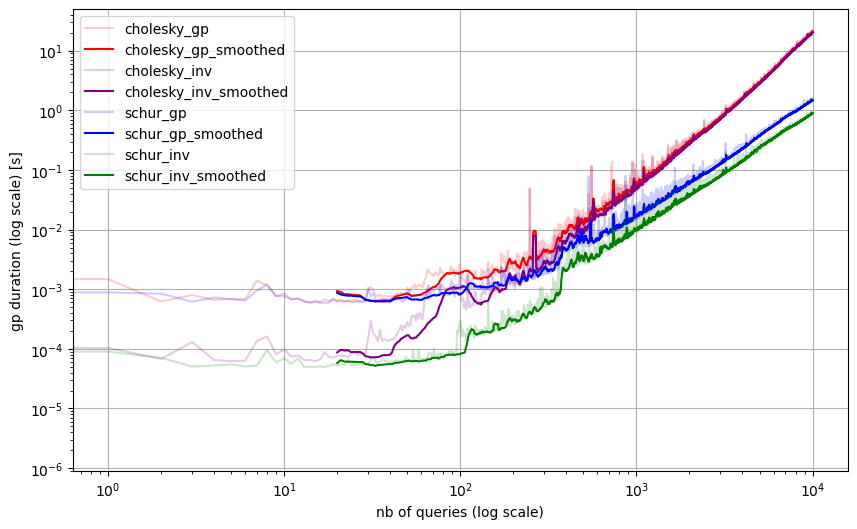

In [13]:
plt.figure(figsize=(10, 6))

plt.loglog(x,gp2_duration, color='red', label='cholesky_gp', alpha=0.2)
plt.loglog(x[smooth_int:],gp2_duration_s, color='red', label='cholesky_gp_smoothed')

plt.loglog(x,inv2_duration, color='purple', label='cholesky_inv', alpha=0.2)
plt.loglog(x[smooth_int:],inv2_duration_s, color='purple', label='cholesky_inv_smoothed')

plt.loglog(x,gp1_duration, color='blue', label='schur_gp', alpha=0.2)
plt.loglog(x[smooth_int:],gp1_duration_s, color='blue', label='schur_gp_smoothed')

plt.loglog(x,inv1_duration, color='green', label='schur_inv', alpha=0.2)
plt.loglog(x[smooth_int:],inv1_duration_s, color='green', label='schur_inv_smoothed')

plt.xlabel('nb of queries (log scale)')
plt.ylabel('gp duration (log scale) [s]')

plt.legend()
plt.grid()
plt.show()

Whith CHOLESKY : 
Calculated exponent (p): 2.64
Coefficient (alpha): 5.04e-10
Whith SCHUR : 
Calculated exponent (p): 1.97
Coefficient (alpha): 1.15e-08


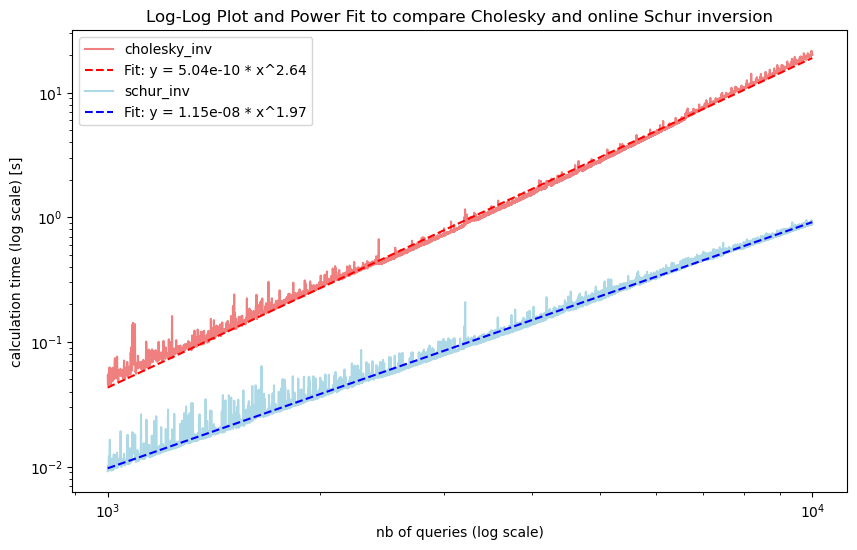

In [14]:
plt.figure(figsize=(10, 6))

## ----- Cholesky ----- ##

# Convert to log scale to fit a line and determine p
log_x = np.log(x[1000:])
log_y = np.log(inv2_duration[1000:])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Display the result for the slope, which corresponds to the power p
print("Whith CHOLESKY : ")
print(f"Calculated exponent (p): {slope:.2f}")
print(f"Coefficient (alpha): {np.exp(intercept):.2e}")

# Plot the log-log graph
plt.loglog(x[1000:], inv2_duration[1000:], label='cholesky_inv', color='lightcoral')
plt.loglog(x[1000:], np.exp(intercept) * x[1000:]**slope, '--', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}', color='red')



## ----- Schur ----- ##

# Convert to log scale to fit a line and determine p
log_x = np.log(x[1000:])
log_y = np.log(inv1_duration[1000:])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Display the result for the slope, which corresponds to the power p
print("Whith SCHUR : ")
print(f"Calculated exponent (p): {slope:.2f}")
print(f"Coefficient (alpha): {np.exp(intercept):.2e}")

# Plot the log-log graph
plt.loglog(x[1000:], inv1_duration[1000:], label='schur_inv', color='lightblue')
plt.loglog(x[1000:], np.exp(intercept) * x[1000:]**slope, '--', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}', color='blue')



# Add labels and legend
plt.xlabel('nb of queries (log scale)')
plt.ylabel('calculation time (log scale) [s]')
plt.title('Log-Log Plot and Power Fit to compare Cholesky and online Schur inversion')
plt.legend()
plt.show()

#### Compare sim

In [15]:
data = np.load("results_custom/gp_and_inv_dur_1rep_5000it_sch_and_cho.npz")
print(data['description'])
gp_dur = data['gp_dur']
inv_dur = data['inv_dur']

gp_dur: array of shape (2, nb_rep=1, nb_it=5000) where gp_dur[0] is the durations of the gp with SCHUR and gp_dur[1] with CHOLESKY
 inv_dur: idem but for the inversion of K duration
 lengthscale=0.4
 noise_std=10


In [16]:
data = np.load("results_custom/gp_and_inv_dur_1rep_2000it_sch.npz")
print(data['description'])
gp_dur1 = data['gp_dur']
inv_dur1 = data['inv_dur']

gp_dur: array of shape (1, nb_rep=1, nb_it=2000) where gp_dur[0] is the durations of the gp with SCHUR
 inv_dur: idem but for the inversion of K duration
 lengthscale=0.4
 noise_std=10


In [17]:
data = np.load("results_custom/gp_and_inv_dur_1rep_2000it_sch_2.npz")
print(data['description'])
gp_dur2 = data['gp_dur']
inv_dur2 = data['inv_dur']

gp_dur: array of shape (1, nb_rep=1, nb_it=2000) where gp_dur[0] is the durations of the gp with SCHUR
 inv_dur: idem but for the inversion of K duration
 lengthscale=0.8
 noise_std=20


In [18]:
smooth_int = 100
inv_duration_s = mean_by_interval(inv_dur[0,0,:2000], smooth_int)
inv1_duration_s = mean_by_interval(inv_dur1[0,0], smooth_int)
inv2_duration_s = mean_by_interval(inv_dur2[0,0], smooth_int)

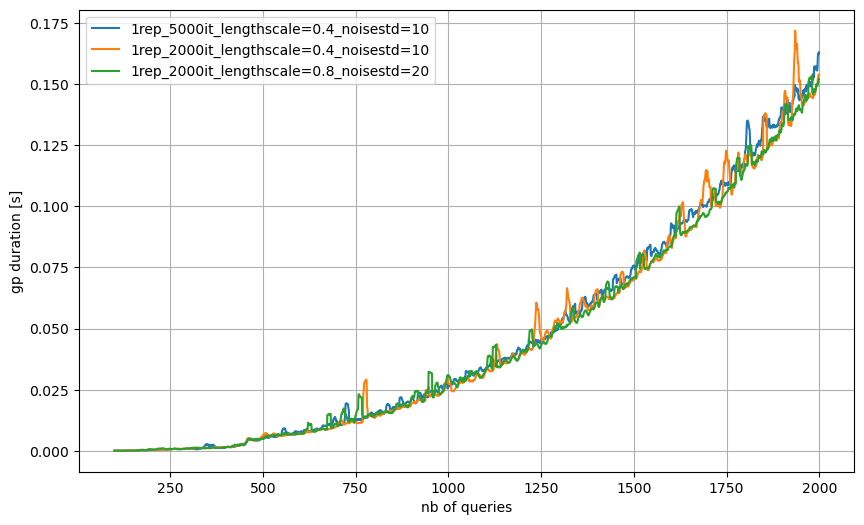

In [19]:
plt.figure(figsize=(10, 6))
x = np.arange(100,2000)
# plt.plot(inv_dur[0,0,:2000])
# plt.plot(inv_dur1[0,0])
# plt.plot(inv_dur2[0,0])
plt.plot(x,inv_duration_s, label='1rep_5000it_lengthscale=0.4_noisestd=10')
plt.plot(x,inv1_duration_s, label='1rep_2000it_lengthscale=0.4_noisestd=10')
plt.plot(x,inv2_duration_s, label='1rep_2000it_lengthscale=0.8_noisestd=20')
plt.xlabel('nb of queries')
plt.ylabel('gp duration [s]')
plt.legend()
plt.grid()
plt.show()

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.utils.transforms import standardize

from GPytorchModel import GPytorchModel


In [2]:

# Générer des données d'entraînement fictives
# Nombre de points d'entraînement
n = 20
train_X = torch.rand(n, 2, dtype=torch.float64)  # Données d'entrée (50 points dans un espace 2D)
train_Y = torch.sin(train_X[:, 0]) + torch.cos(train_X[:, 1]) + 0.1 * torch.randn(n, dtype=torch.float64)  # Fonction cible avec du bruit

train_Y = standardize(train_Y)


In [3]:
print(train_X.shape)
print(train_Y.shape)

torch.Size([20, 2])
torch.Size([20])


Iter 1/100 - Loss: 1.230   Lengthscale: [1.025000000372529, 1.025000000372529]   Outputscale: 1.750   Noise: 0.251    LR: 0.500
Iter 2/100 - Loss: 1.161   Lengthscale: [0.7862043319015333, 0.7862043629726316]   Outputscale: 2.056   Noise: 0.189    LR: 0.500
Iter 3/100 - Loss: 1.183   Lengthscale: [0.6286372334554399, 0.577716528689345]   Outputscale: 2.292   Noise: 0.232    LR: 0.500
Iter 4/100 - Loss: 1.187   Lengthscale: [0.5758349111955432, 0.5929936737972387]   Outputscale: 2.425   Noise: 0.212    LR: 0.500
Iter 5/100 - Loss: 1.173   Lengthscale: [0.606239448191101, 0.6702145288658329]   Outputscale: 2.497   Noise: 0.185    LR: 0.500
Iter 6/100 - Loss: 1.162   Lengthscale: [0.6881880175826931, 0.760170361179602]   Outputscale: 2.540   Noise: 0.178    LR: 0.500
Iter 7/100 - Loss: 1.156   Lengthscale: [0.8017221950685174, 0.8206218371303853]   Outputscale: 2.571   Noise: 0.191    LR: 0.250
Iter 8/100 - Loss: 1.156   Lengthscale: [0.8602450167800101, 0.8320151708344995]   Outputscale:

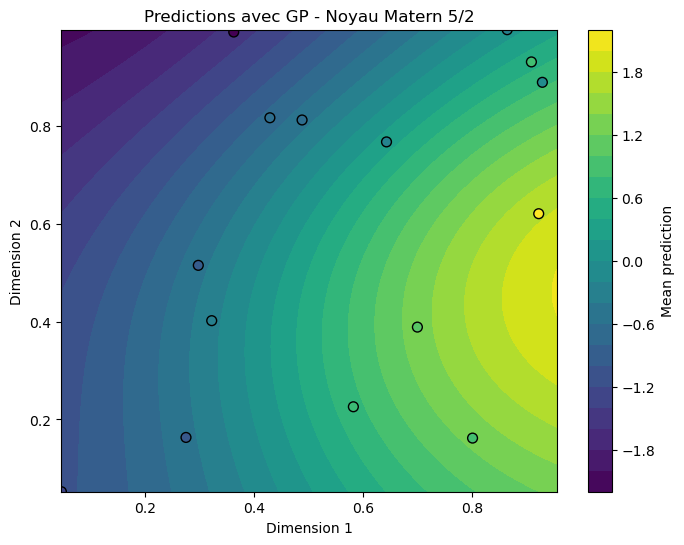

Iter 1/100 - Loss: 1.095   Lengthscale: [0.8767344440853428, 0.7900007726689032]   Outputscale: 2.812   Noise: 0.191    LR: 0.500
Iter 2/100 - Loss: 1.137   Lengthscale: [1.1190314455676675, 1.0290337974122141]   Outputscale: 2.883   Noise: 0.137    LR: 0.500
Iter 3/100 - Loss: 1.095   Lengthscale: [0.9540070189147108, 0.8557093294071149]   Outputscale: 2.922   Noise: 0.166    LR: 0.500
Iter 4/100 - Loss: 1.105   Lengthscale: [0.8033626195945232, 0.696475970003674]   Outputscale: 2.946   Noise: 0.195    LR: 0.500
Iter 5/100 - Loss: 1.117   Lengthscale: [0.7790793514392476, 0.650588968424459]   Outputscale: 2.959   Noise: 0.210    LR: 0.500
Iter 6/100 - Loss: 1.109   Lengthscale: [0.8276098504950418, 0.6880205292473214]   Outputscale: 2.967   Noise: 0.209    LR: 0.500
Iter 7/100 - Loss: 1.097   Lengthscale: [0.9021849753654205, 0.7673847412472835]   Outputscale: 2.972   Noise: 0.197    LR: 0.500
Iter 8/100 - Loss: 1.094   Lengthscale: [0.9667847249128513, 0.8583900351991078]   Outputsca

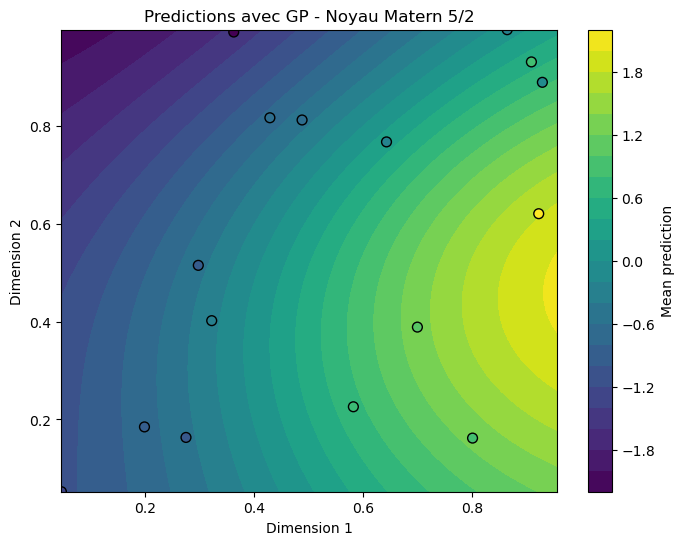

In [4]:
# Définir la vraisemblance
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialiser le modèle avec noyau Matern 5/2
model = GPytorchModel(train_X[:15], train_Y[:15], likelihood, kernel_type='Matern52')

model.double()

# Entraînement du modèle
optimal_hyperparams = model.train_model(train_X[:15], train_Y[:15], max_iters=100, lr=0.5, Verbose=True)

# Afficher les hyperparamètres optimaux après convergence
print("Hyperparamètres optimaux :")
print(optimal_hyperparams)

# Visualisation des résultats (prédiction sur une grille)
model.eval()
likelihood.eval()

# Créer une grille pour les prédictions
x_min, x_max = train_X[:, 0].min().item(), train_X[:, 0].max().item()
y_min, y_max = train_X[:, 1].min().item(), train_X[:, 1].max().item()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

# Faire une prédiction
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = model(grid)

# Reshaper la prédiction pour la visualisation
pred_mean = observed_pred.mean.reshape(xx.shape)
pred_std = observed_pred.variance.sqrt().reshape(xx.shape)

# Visualiser les prédictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_mean.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:15, 0].numpy(), train_X[:15, 1].numpy(), c=train_Y[:15].numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


model.set_train_data(train_X[:16], train_Y[:16], strict=False)

# # Définir la vraisemblance
# likelihood = gpytorch.likelihoods.GaussianLikelihood()

# # Initialiser le modèle avec noyau Matern 5/2
# model = GPytorchModel(train_X[:16], train_Y[:16], likelihood, kernel_type='Matern52')


# Entraînement du modèle
optimal_hyperparams = model.train_model(train_X[:16], train_Y[:16], max_iters=100, lr=0.5, Verbose=True)

# Afficher les hyperparamètres optimaux après convergence
print("Hyperparamètres optimaux :")
print(optimal_hyperparams)

# Visualisation des résultats (prédiction sur une grille)
model.eval()
likelihood.eval()

# Créer une grille pour les prédictions
x_min, x_max = train_X[:, 0].min().item(), train_X[:, 0].max().item()
y_min, y_max = train_X[:, 1].min().item(), train_X[:, 1].max().item()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)


pred_mean, pred_std = model.predict(grid)

pred_mean = pred_mean.reshape(xx.shape)
pred_std = pred_std.reshape(xx.shape)

# Visualiser les prédictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_mean.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:16, 0].numpy(), train_X[:16, 1].numpy(), c=train_Y[:16].numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [24]:
print(dir(likelihood))
print(likelihood.parameters())

['T_destination', '__abstractmethods__', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_added_loss_terms', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_clear_cache', '_compiled_call_impl', '_constraints', '_draw_likelihood_samples', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_module_and_name', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_ho

In [25]:

# Définir la vraisemblance
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Initialiser le modèle avec noyau Matern 5/2
model = GPytorchModel(train_X, train_Y, likelihood, kernel_type='Matern52')

# Entraînement du modèle
optimal_hyperparams = model.train_model(train_X, train_Y, max_iters=100, lr=0.5)

# Afficher les hyperparamètres optimaux après convergence
print("Hyperparamètres optimaux :")
print(optimal_hyperparams)

# Visualisation des résultats (prédiction sur une grille)
model.eval()
likelihood.eval()

# Créer une grille pour les prédictions
x_min, x_max = train_X[:, 0].min().item(), train_X[:, 0].max().item()
y_min, y_max = train_X[:, 1].min().item(), train_X[:, 1].max().item()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

# Faire une prédiction
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = model(grid)

# Reshaper la prédiction pour la visualisation
pred_mean = observed_pred.mean.reshape(xx.shape)
pred_std = observed_pred.variance.sqrt().reshape(xx.shape)

# Visualiser les prédictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_mean.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c=train_Y.numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


KeyboardInterrupt: 

In [6]:
f_preds = model(grid)
y_preds = likelihood(f_preds)

In [8]:
f_mean = f_preds.mean
f_var = f_preds.variance

y_mean = y_preds.mean
y_var = y_preds.variance

print(f_mean-y_mean)
print(f_var-y_var)


tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64,
       grad_fn=<SubBackward0>)
tensor([-0.0506, -0.0506, -0.0506,  ..., -0.0506, -0.0506, -0.0506],
       dtype=torch.float64, grad_fn=<SubBackward0>)


In [166]:
print(grid.shape)
print(pred_mean.shape)

torch.Size([10000, 2])
torch.Size([100, 100])


In [7]:
pred_mean_1 = pred_mean
pred_std_1 = pred_std

In [11]:
print(torch.max(pred_mean_1-pred_mean))

tensor(0., dtype=torch.float64)


In [1]:
import numpy as np
import torch
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize
from GPytorchModel import GPytorchModel
from BOtorchModel import BOtorchModel

{'lengthscale': [1.8256032089577354, 2.815001526408643], 'outputscale': 6.211025046885684, 'noise': 0.07598837646555183}
torch.Size([10000]) torch.Size([10000])


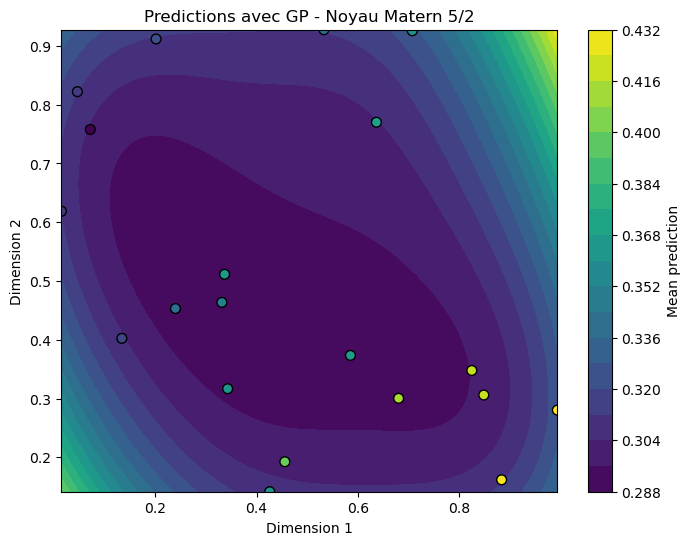

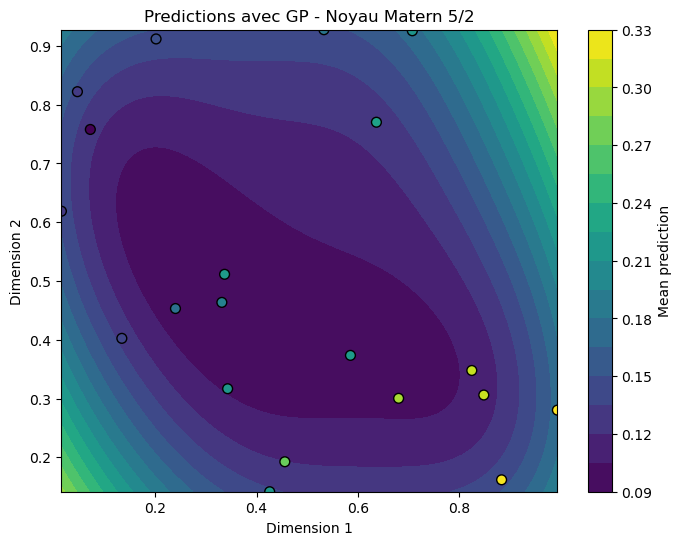

In [5]:

# Instanciation du modèle
model = BOtorchModel(train_X, train_Y.reshape(-1,1))

# Conversion explicite du modèle en double précision
model.double()

# Ajustement du modèle
model.fit_model()
print(model.get_hyperparameters())

# Créer une grille pour les prédictions
x_min, x_max = train_X[:, 0].min().item(), train_X[:, 0].max().item()
y_min, y_max = train_X[:, 1].min().item(), train_X[:, 1].max().item()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

pred_mean = model.posterior(grid).mean.flatten().reshape(xx.shape) # GP prediction for the mean
pred_std = torch.sqrt(model.posterior(grid).variance.flatten()).reshape(xx.shape) # GP prediction for the variance

# Prédictions
mean, std = model.predict(grid)
print(mean.shape, std.shape)

mean = mean.reshape(xx.shape)
std = std.reshape(xx.shape)

# Visualiser les prédictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, std.detach().numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c=train_Y.numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# Visualiser les prédictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_std.detach().numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c=train_Y.numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [24]:
print(torch.max(torch.abs(pred_mean-mean)))
print(torch.max(torch.abs(pred_std-std)))

tensor(4.4409e-16, dtype=torch.float64, grad_fn=<MaxBackward1>)
tensor(0.1711, dtype=torch.float64, grad_fn=<MaxBackward1>)


In [1]:
import numpy as np
import torch
import gpytorch
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.utils.transforms import standardize
from GPytorchModel import GPytorchModel
from BOtorchModel import BOtorchModel

In [2]:
# Génération de données d'exemple avec précision double
#train_X = torch.linspace(0, 1, 6, dtype=torch.float64).view(-1, 1)
train_X = torch.rand(10, dtype=torch.float64).view(-1, 1)
my_train_Y = (torch.sin(train_X * (2 * torch.pi)) + 0.1 * torch.randn_like(train_X))

# train_X = torch.rand(15, 2)  # Données d'entrée (50 points dans un espace 2D)
# train_Y = torch.sin(train_X[:, 0]) + torch.cos(train_X[:, 1]) + 0.1 * torch.randn(15)  # Fonction cible avec du bruit

my_train_Y = standardize(my_train_Y)


In [43]:
print(train_X.shape)
print(train_Y.shape)

torch.Size([15, 1])
torch.Size([15])


In [3]:
train_Y = my_train_Y
# Instanciation du modèle
model = BOtorchModel(train_X, train_Y)

# Conversion explicite du modèle en double précision
model.double()

# Ajustement du modèle
mll_bo = model.fit_model()

# Génération de points de test avec précision double
test_X = torch.linspace(0, 1, 200, dtype=torch.float64).view(-1, 1)

mean = model.posterior(test_X).mean.flatten() # GP prediction for the mean
std = torch.sqrt(model.posterior(test_X).variance.flatten()) # GP prediction for the variance

# Affichage des résultats
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_X.numpy(), train_Y.numpy(), 'k*', label='Training Data')
plt.plot(test_X.numpy(), mean.detach().numpy(), 'b', label='Mean Prediction')
plt.fill_between(test_X.squeeze().numpy(), mean.detach().numpy()-1.96*std.detach().numpy(), mean.detach().numpy()+1.96*std.detach().numpy(), color='blue', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.show()

c:\Users\deleu\miniconda3\envs\mtl\Lib\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


NameError: name 'train_Y' is not defined

In [121]:
print(
        f'Lengthscale 1: {model.covar_module.base_kernel.lengthscale[0,0].item():.3f}   '
        #f'Lengthscale 2: {self.covar_module.base_kernel.lengthscale[0,1].item():.3f}   '
        f'Outputscale: {model.covar_module.outputscale.item():.3f}   '
        f'Noise std: {model.likelihood.noise.item():.3f}')

Lengthscale 1: 0.194   Outputscale: 1.373   Noise std: 0.024


Iter 1/100 - Loss: 1.278   Lengthscale: tensor([0.6931], grad_fn=<SelectBackward0>)   Outputscale: 0.693   Noise std: 0.693
Iter 2/100 - Loss: 1.124   Lengthscale: tensor([0.4741], grad_fn=<SelectBackward0>)   Outputscale: 0.974   Noise std: 0.474
Iter 3/100 - Loss: 0.965   Lengthscale: tensor([0.3135], grad_fn=<SelectBackward0>)   Outputscale: 1.313   Noise std: 0.315
Iter 4/100 - Loss: 0.887   Lengthscale: tensor([0.2159], grad_fn=<SelectBackward0>)   Outputscale: 1.448   Noise std: 0.204
Iter 5/100 - Loss: 0.792   Lengthscale: tensor([0.2025], grad_fn=<SelectBackward0>)   Outputscale: 1.317   Noise std: 0.129
Iter 6/100 - Loss: 0.664   Lengthscale: tensor([0.2271], grad_fn=<SelectBackward0>)   Outputscale: 1.108   Noise std: 0.080
Iter 7/100 - Loss: 0.554   Lengthscale: tensor([0.2749], grad_fn=<SelectBackward0>)   Outputscale: 0.889   Noise std: 0.050
Iter 8/100 - Loss: 0.538   Lengthscale: tensor([0.3194], grad_fn=<SelectBackward0>)   Outputscale: 0.722   Noise std: 0.031
Iter 9/1

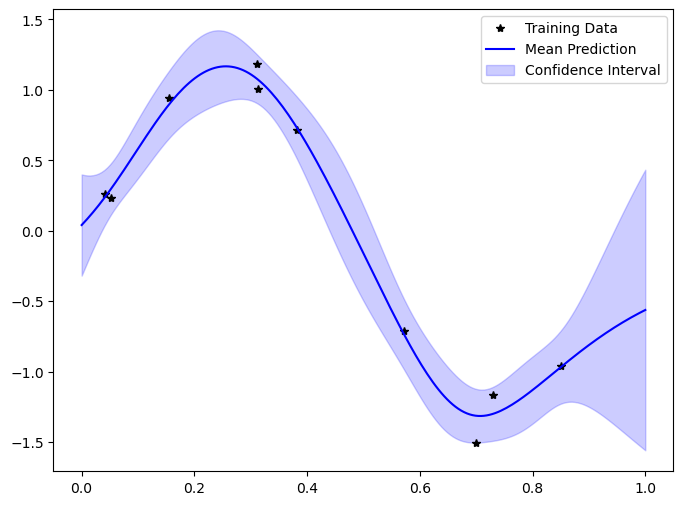

In [8]:
train_Y = my_train_Y[:,0]

# Définir la vraisemblance
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Instanciation du modèle
model = GPytorchModel(train_X, train_Y, likelihood, kernel_type='Matern52')

# Entraînement du modèle
optimal_hyperparams = model.train_model(train_X, train_Y, max_iters=100, lr=0.5)

# Génération de points de test avec précision double
test_X = torch.linspace(0, 1, 200, dtype=torch.float64).view(-1, 1)

# Visualisation des résultats (prédiction sur une grille)
model.eval()
likelihood.eval()

# Faire une prédiction
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = model(test_X)

# Reshaper la prédiction pour la visualisation
pred_mean = observed_pred.mean.reshape(test_X.shape)[:,0]
pred_variance = observed_pred.variance.reshape(test_X.shape)[:,0]

# Affichage des résultats
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_X.numpy(), train_Y.numpy(), 'k*', label='Training Data')
plt.plot(test_X.numpy(), pred_mean.numpy(), 'b', label='Mean Prediction')
plt.fill_between(test_X.squeeze().numpy(), pred_mean.numpy()-1.96*np.sqrt(pred_variance.numpy()), pred_mean.numpy()+1.96*np.sqrt(pred_variance.numpy()), color='blue', alpha=0.2, label='Confidence Interval')
plt.legend()
plt.show()

In [4]:
print(pred_variance)

tensor([0.0047, 0.0043, 0.0043, 0.0045, 0.0048, 0.0051, 0.0054, 0.0055, 0.0055,
        0.0054, 0.0052, 0.0049, 0.0046, 0.0044, 0.0043, 0.0042, 0.0043, 0.0044,
        0.0046, 0.0047, 0.0049, 0.0049, 0.0049, 0.0048, 0.0047, 0.0045, 0.0043,
        0.0042, 0.0041, 0.0041, 0.0042, 0.0043, 0.0045, 0.0047, 0.0048, 0.0049,
        0.0049, 0.0049, 0.0047, 0.0045, 0.0043, 0.0042, 0.0041, 0.0041, 0.0042,
        0.0043, 0.0045, 0.0047, 0.0048, 0.0049, 0.0049, 0.0049, 0.0047, 0.0046,
        0.0044, 0.0042, 0.0041, 0.0041, 0.0041, 0.0043, 0.0044, 0.0046, 0.0048,
        0.0049, 0.0049, 0.0049, 0.0048, 0.0046, 0.0044, 0.0042, 0.0041, 0.0041,
        0.0041, 0.0042, 0.0044, 0.0046, 0.0048, 0.0049, 0.0049, 0.0049, 0.0048,
        0.0046, 0.0045, 0.0043, 0.0041, 0.0041, 0.0041, 0.0042, 0.0044, 0.0045,
        0.0047, 0.0049, 0.0049, 0.0049, 0.0048, 0.0047, 0.0045, 0.0043, 0.0042,
        0.0041, 0.0041, 0.0042, 0.0043, 0.0045, 0.0047, 0.0048, 0.0049, 0.0049,
        0.0049, 0.0047, 0.0045, 0.0044, 

In [6]:
model.likelihood.noise

tensor([0.6932], grad_fn=<AddBackward0>)

In [6]:
model.covar_module.base_kernel.lengthscale

tensor([[0.6931, 0.6931]], grad_fn=<SoftplusBackward0>)

In [9]:
model.covar_module.outputscale


tensor(0.6931, grad_fn=<SoftplusBackward0>)

In [10]:
model.covar_module

ScaleKernel(
  (base_kernel): MaternKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

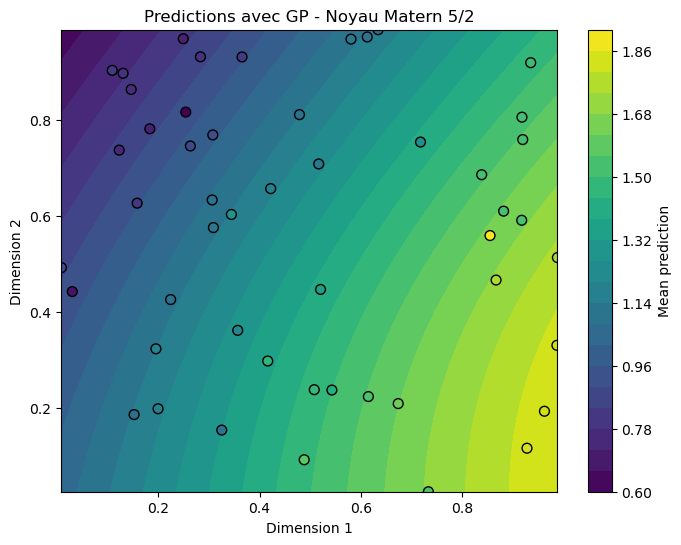

In [2]:
# Visualiser les prédictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_mean.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c=train_Y.numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()